# Plotting Scripts
Copyright (c) 2025 University of Salerno SPDX-License-Identifier: Apache-2.0

Run this whole Jupyter to produce the paper plots.

### Initialization

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from rdkit import Chem
import os
import sys
import networkx as nx
from tqdm import tqdm
import subprocess

sns.set_theme(style="whitegrid")

In [2]:
# time in ms, memory in bytes
class SIGMOParser:
  def __init__(self, out, err = ''):
    if err:
      self.candidates_sizes = []
      self._parseNumCandidates(err)
    self._lines = [line.strip() for line in out.split('\n')]
    self.parse()
    self.n_refinement_steps = 0
  
  def _parseMemory(self, value, unit):
    value = float(value)
    if unit == 'B':
      return value
    elif unit == 'KB':
      return value * 1024
    elif unit == 'MB':
      return value * 1024 * 1024
    elif unit == 'GB':
      return value * 1024 * 1024 * 1024
  
  def _parseGPUStats(self, start):
    for i in range(1, 6):
      line = self._lines[start + i]
      if line.startswith('Data signature time'):
        self.data_signature_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Query signature time'):
        self.query_signature_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Filter time'):
        self.filter_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Join time'):
        self.join_gpu_time = int(line.split(' ')[-2])
      elif line.startswith('Total time:'):
        self.total_gpu_time = int(line.split(' ')[-2])
      
  def _parseConfigs(self, start):
    for i in range(1, 5):
      line = self._lines[start + i]
      if line.startswith('Filter domain'):
        self.filter_domain = line.split(' ')[-1]
      elif line.startswith('Filter Work Group Size'):
        self.filter_work_group_size = int(line.split(' ')[-1])
      elif line.startswith('Join Work Group Size'):
        self.join_work_group_size = int(line.split(' ')[-1])
      elif line.startswith('Find all'):
        self.find_all = line.split(' ')[-1] == 'Yes'

  def _parseHostStats(self, start):
    for i in range(1, 6):
      line = self._lines[start + i]
      if line.startswith('Setup Data time'):
        self.setup_data_host_time = int(line.split(' ')[3])
      elif line.startswith('Filter time'):
        self.filter_host_time = int(line.split(' ')[-2])
      elif line.startswith('Mapping time'):
        self.mapping_host_time = int(line.split(' ')[-2])
      elif line.startswith('Join time'):
        self.join_host_time = int(line.split(' ')[-2])
      elif line.startswith('Total time:'):
        self.total_time = int(line.split(' ')[-2])
  
  def _parseNumCandidates(self, err):
    for line in err.split('\n'):
      if line.startswith('Node'):
        self.candidates_sizes.append(int(line.split(' ')[-1]))
  
  def parse(self):
    for i, line in enumerate(self._lines):
      if line.startswith('# Query Nodes'):
        self.n_query_nodes = int(line.split(' ')[-1])
      elif line.startswith('# Query Graphs'):
        self.n_query_graphs = int(line.split(' ')[-1])
      elif line.startswith('# Data Nodes'):
        self.n_data_nodes = int(line.split(' ')[-1])
      elif line.startswith('# Data Graphs'):
        self.n_data_graphs = int(line.split(' ')[-1])
      elif "Configs" in line:
        self._parseConfigs(i)
      elif line.endswith('B for graph data'):
        self.graph_data_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for query data'):
        self.query_data_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for candidates'):
        self.candidates_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for data signatures'):
        self.data_signatures_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.endswith('B for query signatures'):
        self.query_signatures_memory = self._parseMemory(line.split(' ')[1], line.split(' ')[2])
      elif line.startswith('Total allocated memory'):
        self.total_memory = self._parseMemory(line.split(' ')[3], line.split(' ')[4])
      elif line.startswith('# Total candidates:'):
        self.n_total_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Average candidates:'):
        self.n_avg_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Median candidates:'):
        self.n_median_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Zero candidates:'):
        self.n_zero_candidates = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('# Matches:'):
        self.n_matches = int(line.split(' ')[-1].replace('.', ''))
      elif line.startswith('[*] Refinement step'):
        self.n_refinement_steps = int(line.split(' ')[-1].replace(':', ''))
      elif "Overall GPU Stats" in line:
        self._parseGPUStats(i)
      elif "Overall Host Stats" in line:
        self._parseHostStats(i)
      elif line.startswith("Node 0:"):
        self._parseNumCandidates(i)
  
  def get_df_str(self):
    header = []
    vals = []
    for key, value in sorted(self.__dict__.items(), key=lambda x: x[0]):
      if key.startswith('_'):
        continue
      header.append(key)
      if (key == 'candidates_sizes'):
        v = '-'.join([str(x) for x in value])
        vals.append(v)
      else:
        vals.append(str(value))
    return header, vals

  def get_df_headers(self):
    return list(sorted(self.__dict__.keys()))
      

# Create a function to set the font size for specific figures
def set_font_size(ax, size):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)

## Section 4

In [18]:
def molToGraph(mol):
  graph = nx.Graph()
  for atom in mol.GetAtoms():
    graph.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
  for bond in mol.GetBonds():
    graph.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
  return graph

molecules = []
patterns = []

with open('./data/data.smarts') as f:
  for line in tqdm(f):
    mol = Chem.MolFromSmiles(line.strip())
    graph = molToGraph(mol)
    molecules.append(graph)

with open('./data/query.smarts') as f:
  for line in tqdm(f):
    mol = Chem.MolFromSmarts(line.strip())
    graph = molToGraph(mol)
    patterns.append(graph)


0it [00:00, ?it/s]

114901it [00:53, 2146.47it/s]
619it [00:00, 11948.87it/s]


### Histogram Nodes Degree

In [5]:
degree_df = pd.DataFrame(columns=['Degree', 'Type'])

query_degrees = []
for graph in molecules:
  for node in graph.nodes:
    query_degrees.append(graph.degree(node))

data_degrees = []
for graph in patterns:
  for node in graph.nodes:
    data_degrees.append(graph.degree(node))

query_df = pd.DataFrame(query_degrees, columns=['Degree'])
query_df['Type'] = 'Pattern'

data_df = pd.DataFrame(data_degrees, columns=['Degree'])
data_df['Type'] = 'Molecule'

degree_df = pd.concat([query_df, data_df])

del query_degrees, data_degrees, query_df, data_df


Number of query graphs with degree > 4: 0
Number of data graphs with degree > 4: 18


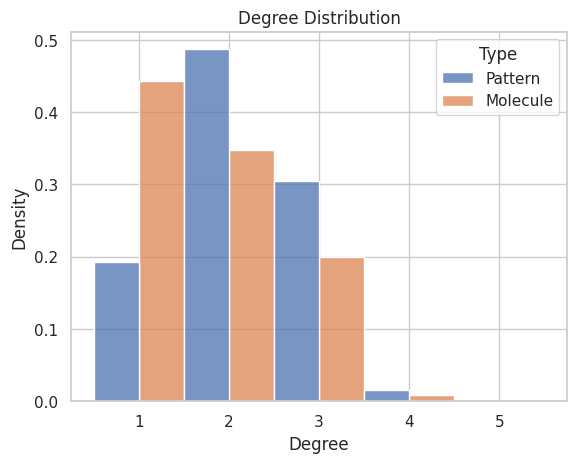

In [ ]:
g = sns.histplot(degree_df, x='Degree', hue='Type', discrete=True, common_norm=False, stat='density', multiple='dodge', binwidth=0.7, element='bars')
g.title.set_text('Degree Distribution')

## Section 6 (Experimental Evaluation)

### Run experiments

In [7]:
exec_path = "./build/sigmo"
exec_args = ["-Q", "./data/SIGMO/query.dat", "-D", "./data/SIGMO/data.dat", "-c", "query", "-p"]
MAX_ITERS = 8

outputs = []

for i in range(MAX_ITERS):
  curr_args = exec_args + ["--find-all", "-i", f"{i}"]
  print(f"Running {exec_path} {' '.join(curr_args)}")
  out = subprocess.run([exec_path] + curr_args, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  output = out.stdout.decode('utf-8')
  error = out.stderr.decode('utf-8')
  outputs.append((output, error))

for i in range(MAX_ITERS):
  curr_args = exec_args + ["-i", f"{i}"]
  print(f"Running {exec_path} {' '.join(curr_args)}")
  out = subprocess.run([exec_path] + curr_args, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  output = out.stdout.decode('utf-8')
  error = out.stderr.decode('utf-8')
  outputs.append((output, error))

Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p --find-all -i 0
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p --find-all -i 1
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p --find-all -i 2
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p --find-all -i 3
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p --find-all -i 4
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p --find-all -i 5
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p --find-all -i 6
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p --find-all -i 7
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p -i 0
Running ./build/sigmo -Q ./data/SIGMO/query.dat -D ./data/SIGMO/data.dat -c query -p -i 1
Running ./bu

In [17]:
headers = []
vals = []
for out, err in outputs:
  out = SIGMOParser(out, err)
  if len(headers) == 0:
    headers = out.get_df_str()[0]
  vals.append(out.get_df_str()[1])

df = pd.DataFrame(columns=headers)
for val in vals:
  df.loc[len(df)] = val

if not os.path.exists('./out/SIGMO'):
  os.makedirs('./out/SIGMO')
df.to_csv('./out/SIGMO/sigmo_results.csv', index=False)
del df, headers, vals


### Read

In [3]:
sigmo_df = pd.read_csv('./out/SIGMO/sigmo_results.csv')
# sort according to the number of refinement steps
sigmo_df = sigmo_df.sort_values(by='n_refinement_steps')

### Filter VS Join

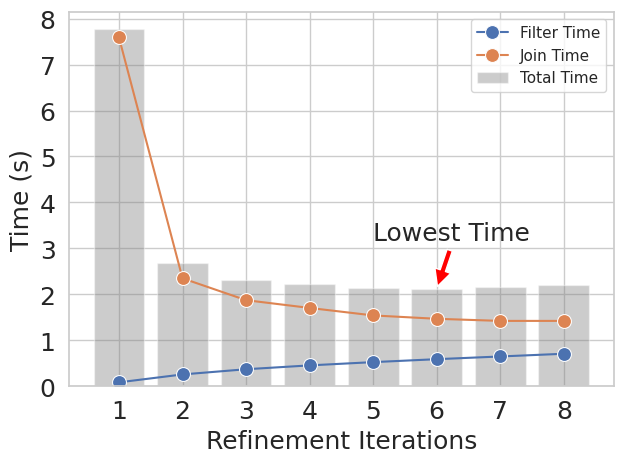

In [173]:
FONTSIZE = 18
fig, axs = plt.subplots()

filter_time = [result.filter_gpu_time / 1000 for result in sigmo_df[sigmo_df['find_all']].itertuples()]
join_time = [result.join_gpu_time / 1000 for result in sigmo_df[sigmo_df['find_all']].itertuples()]
total_time = [result.total_time / 1000 for result in sigmo_df[sigmo_df['find_all']].itertuples()]

# Create a DataFrame
iterations = list(range(1, len(filter_time) + 1))
data = pd.DataFrame({
    'Iterations': iterations,
    'Filter Time': filter_time,
    'Join Time': join_time
})

# Calculate total time
data['Total Time'] = total_time

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Iterations', value_vars=['Filter Time', 'Join Time'], var_name='Type', value_name='Time')


# Create the line plot
sns.lineplot(data=data_melted, x='Iterations', y='Time', hue='Type', marker='o', markersize=10, ax=axs)

# Add the total time bars
axs.bar(data['Iterations'], data['Total Time'], color='gray', alpha=0.4, label='Total Time')

# Add labels and title
axs.set_xlabel('Refinement Iterations')
axs.set_ylabel('Time (s)')

# get the lowest bar and add a label to mark that is the lowest, add also an arrow
lowest_bar = min(data['Total Time'])
axs.annotate('Lowest Time', xy=(data['Iterations'][data['Total Time'].idxmin()], lowest_bar),
             xytext=(data['Iterations'][data['Total Time'].idxmin()] - 1, lowest_bar + lowest_bar * .5),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=FONTSIZE)


# Add legend
axs.legend()
set_font_size(axs, 18)

# Show the plot
fig.tight_layout()
fig.savefig('./out/plots/filter_join_time.pdf')
fig.show()

### Number of Candidates

In [ ]:

candidates_sizes = sigmo_df[sigmo_df['find_all']]['candidates_sizes']
# Convert strings into numeric arrays (Nodes × Iterations)
candidate_matrix = np.array(candidates_sizes.apply(lambda x: [int(i) for i in x.split('-')]).tolist()).T

data_for_scatter = pd.DataFrame({
    'Iteration': np.tile(np.arange(candidate_matrix.shape[1]), candidate_matrix.shape[0]),
    'Node': np.repeat(np.arange(candidate_matrix.shape[0]), candidate_matrix.shape[1]),
    'CandidateSize': candidate_matrix.flatten()
})
data_for_scatter['Iteration'] += 1

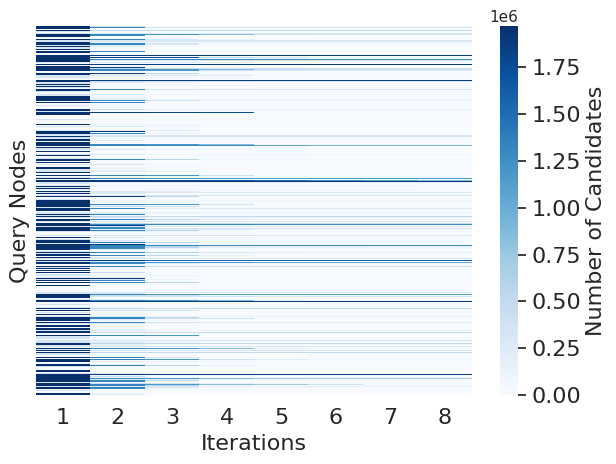

In [75]:
FONTSIZE = 16

fig, axs = plt.subplots()  # Adjust the height by increasing the second value

sns.heatmap(candidate_matrix, ax=axs, cmap='Blues')  # Adjust color bar size

axs.set_xlabel('Iterations', fontsize=FONTSIZE)
axs.set_ylabel('Query Nodes', fontsize=FONTSIZE)
axs.yaxis.set_ticks([])
axs.tick_params(axis='both', which='major')
# increment the xticks labels by 1
axs.set_xticklabels([str(i + 1) for i in range(candidate_matrix.shape[1])])

cbar = axs.collections[0].colorbar
cbar.set_label('Number of Candidates', fontsize=FONTSIZE)

# set the font size of the color bar
cbar.ax.tick_params(labelsize=FONTSIZE)

set_font_size(axs, FONTSIZE)

fig.tight_layout()
fig.savefig('./out/plots/candidates_heatmap.pdf')
fig.show()


/tmp/ipykernel_3123963/493426229.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df = data_for_scatter.groupby('Iteration', group_keys=False).apply(find_outliers)


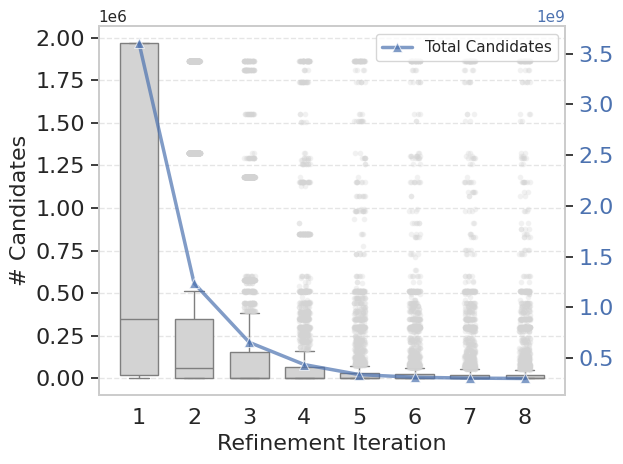

In [41]:
FONTSIZE = 16
COLOR=sns.color_palette()[0]
fig, ax1 = plt.subplots()

# Function to get outliers
def find_outliers(group):
    values = group['CandidateSize']
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return group[(values < lower) | (values > upper)]

outliers_df = data_for_scatter.groupby('Iteration', group_keys=False).apply(find_outliers)

sns.boxplot(data=data_for_scatter, 
            x='Iteration', 
            y='CandidateSize', 
            flierprops=dict(marker='.', markersize=4), 
            ax=ax1, 
            color="lightgray",
            width=0.7,
            showfliers=False,
            )
sns.stripplot(
    data=outliers_df,
    x='Iteration',
    y='CandidateSize',
    ax=ax1,
    jitter=True,
    size=4,
    color='lightgray',
    alpha=0.3
)

ax1.set_xlabel('Refinement Iteration', fontsize=FONTSIZE)
ax1.set_ylabel('# Candidates', fontsize=FONTSIZE)
set_font_size(ax1, FONTSIZE)

# Secondary axis for the total sum of candidates per iteration
ax2 = ax1.twinx()
total_candidates = data_for_scatter.groupby('Iteration')['CandidateSize'].sum().reset_index()

sns.lineplot(data=total_candidates['CandidateSize'], ax=ax2, marker='^', linestyle='-', label='Total Candidates', linewidth=2.5, markersize=7, alpha=.7, color=COLOR)
ax2.set_ylabel('')
ax2.tick_params(axis='y', labelcolor=COLOR)
set_font_size(ax2, FONTSIZE)
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
# ax2.grid(True, axis='y', linestyle='--', alpha=0.5, color=sns.color_palette()[0])
ax2.grid(False)

fig.tight_layout()
fig.savefig('./out/plots/candidates_size.pdf')
fig.show()

/tmp/ipykernel_3123963/2559492757.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


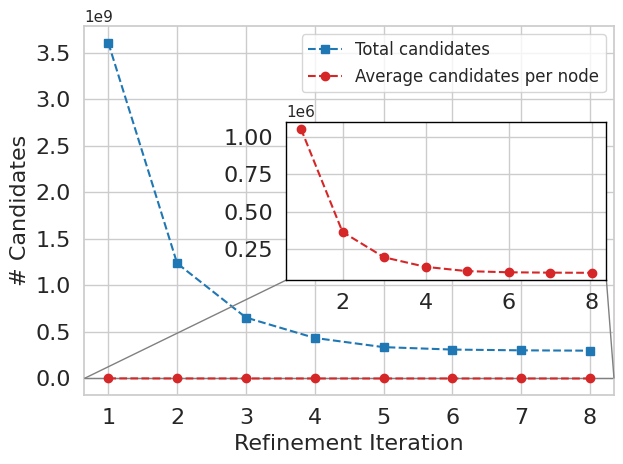

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

total_candidates = sigmo_df[sigmo_df['find_all']]['n_total_candidates']
avg_candidates = sigmo_df[sigmo_df['find_all']]['n_avg_candidates']
median_candidates = sigmo_df[sigmo_df['find_all']]['n_median_candidates']


# Create a DataFrame
iterations = list(range(1, len(total_candidates) + 1))
data = pd.DataFrame({
    'Iterations': iterations,
    'Total Candidates': total_candidates,
    'Average Candidates': avg_candidates,
    'Median Candidates': median_candidates,
})

# Create the line plot
fig, ax1 = plt.subplots()

ax1.set_ylabel('# Candidates')
ax1.set_xlabel('Refinement Iteration')
ax1.plot(iterations, total_candidates, marker='s', linestyle='dashed', color='tab:blue', label='Total candidates')
ax1.plot(iterations, avg_candidates, marker='o', linestyle='dashed', color='tab:red', label='Average candidates per node')

# create inset axes to show the average candidates
ax2 = fig.add_axes([0.46, 0.4, 0.5, 0.33])
ax2.plot(iterations, avg_candidates, marker='o', linestyle='dashed', color='tab:red')
# set bold border
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)
    

mark_inset(ax1, ax2, loc1=3, loc2=4, fc="none", ec="0.5")

ax1.legend(loc='upper right', fontsize=FONTSIZE - 4)
set_font_size(ax1, FONTSIZE)
set_font_size(ax2, FONTSIZE)

# Show the plot
fig.tight_layout()
fig.savefig('./out/plots/candidates_size.pdf')
fig.show()

### Comparison Against SOTA

In [188]:
sota_df = pd.DataFrame(columns=['benchmark','total_time','first_solution_time','matches',])
benchmarks = ['VF3', 'GSI', 'CuTS']

# get the best result (lowest time for find all) from the sigmo_df
best_result_find_all = min(sigmo_df[sigmo_df['find_all']].itertuples(), key=lambda x: x.total_time)
result_find_first = min(sigmo_df[~sigmo_df['find_all']].itertuples(), key=lambda x: x.total_time)

sota_df.loc[len(sota_df)] = ['SIGMo', best_result_find_all.total_time / 1000, result_find_first.total_time / 1000, best_result_find_all.n_matches]

for b in benchmarks:
  benchmark = b
  total_time = 0
  first_solution_time = 0
  matches = 0
  with open(f'./out/{b}/{b}.txt') as f:
    for line in f:
      if line.startswith('Total time (s):'):
        total_time = float(line.split(' ')[-1])
      elif line.startswith('First match time (s):'):
        first_solution_time = float(line.split(' ')[-1])
      elif line.startswith('Total matches:'):
        matches = int(line.split(' ')[-1].replace(',', ''))
      if first_solution_time == total_time:
        first_solution_time = 0
  sota_df.loc[len(sota_df)] = [benchmark, total_time, first_solution_time, matches]
  
sota_df['throughput'] = sota_df['matches'] / sota_df['total_time']
  

#### Time

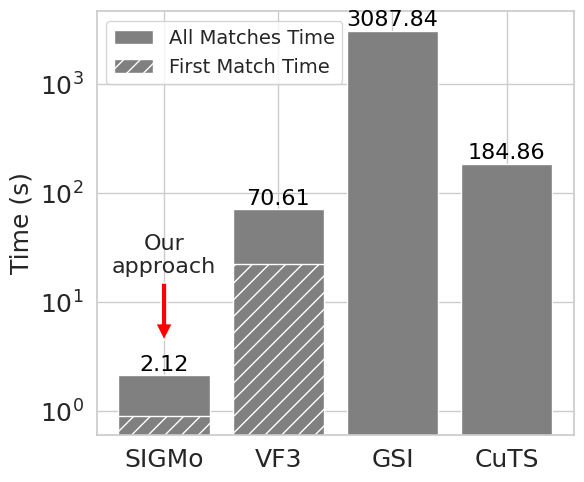

In [189]:
fig, axs = plt.subplots(figsize=(6, 5))
FONTSIZE=16
set_font_size(axs, 18)

axs.bar(sota_df['benchmark'], sota_df['total_time'], color=['gray', 'gray', 'gray'])
axs.bar(sota_df['benchmark'], sota_df['first_solution_time'], hatch='//', color=['gray', 'gray', 'gray'])

positions = []
for i, row in sota_df.iterrows():
    if row['first_solution_time'] == 0:
        positions.append((i, row['total_time']))

# # Annotate the text only once
# if positions:
#     first_position = positions[0]
#     axs.text(first_position[0] - 1.5, first_position[1] / 12, 
#              'Always find\nall matches', 
#              ha='center', va='bottom',
#              fontsize=FONTSIZE)  # Center the text horizontally and align it vertically at the bottom

#     # Create arrows for all positions
#     for pos in positions:
#         axs.annotate('', 
#                      xy=(pos[0] - .3, pos[1] / 2), 
#                      xytext=(first_position[0] - 1, first_position[1] / 6),  # Point to the same text position
#                      arrowprops=dict(facecolor='black', shrink=0.005))

axs.annotate("Our\napproach", 
             xy=(0, sota_df.loc[0, 'total_time'] + 2), 
             xytext=(0, sota_df.loc[0, 'total_time'] + 15), 
             ha='center', va='bottom',  # Center the text horizontally and align it vertically at the bottom
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=FONTSIZE)

# write the time on top of each bar
for i, row in sota_df.iterrows():
  axs.text(i, row['total_time'] + row['total_time'] * 0.02,
           f'{row["total_time"]:.2f}', 
           ha='center', 
           va='bottom', 
           color='black', 
          #  fontweight='bold',
           fontsize=FONTSIZE
           )

axs.set_yscale('log', base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9])
axs.set_ylabel('Time (s)')
axs.set_xlabel('')

axs.legend(['All Matches Time', 'First Match Time'], loc='upper left', fontsize=FONTSIZE-2)
fig.tight_layout()
fig.savefig('./out/plots/sota_time.pdf')
fig.show()

#### Throughput
Matches per second

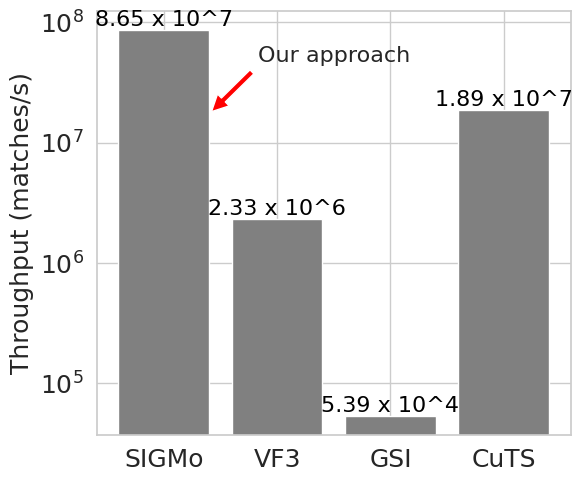

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))
FONTSIZE=16
set_font_size(axs, 18)
axs.bar(sota_df['benchmark'], sota_df['throughput'], color=['gray', 'gray', 'gray'])

axs.annotate("Our approach", 
             xy=(0.4, sota_df.loc[0, 'throughput'] - sota_df.loc[0, 'throughput'] * 0.8), 
             xytext=(1.5, sota_df.loc[0, 'throughput'] - sota_df.loc[0, 'throughput'] * 0.5), 
             ha='center', va='bottom',  # Center the text horizontally and align it vertically at the bottom
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=FONTSIZE)

# write the time on top of each bar
for i, row in sota_df.iterrows():
  thorughput_string = f'{row["throughput"]:.2e}'
  thorughput_string = thorughput_string.replace('e+0', ' x 10^').replace('e+', ' x 10^').replace('e-0', ' / 10^').replace('e-', ' / 10^')
  axs.text(i, row['throughput'] + row['throughput'] * 0.005,
           thorughput_string,
           ha='center', 
           va='bottom', 
           color='black', 
          #  fontweight='bold',
           fontsize=FONTSIZE 
           )

axs.set_ylabel('Throughput (matches/s)')
axs.set_xlabel('')
axs.set_yscale('log', base=10, subs=[2, 3, 4, 5, 6, 7, 8, 9])

fig.tight_layout()
fig.savefig('./out/plots/sota_throughput.pdf')
fig.show()

### GPU Utilization

In [192]:
import os
import signal
import subprocess
import pandas as pd

EVENTS = [
        #   "203",  # GPU Utilization
        #   "1002", # SM Active
          "1003", # SM Occupancy
          ]
PROFILING_SAMPLE = 10 # ms

try:
    # Start dcgmi dmon in the background
    dcgmi_process = subprocess.Popen(
        ["dcgmi", "dmon", "-e", ",".join(EVENTS), "-d", f"{PROFILING_SAMPLE}"],
        stdout=subprocess.PIPE,
        text=True 
    )

    # Run the application
    app_process = subprocess.run(
        ["./build/sigmo", "-i", "4", "-c", "query", "-Q", "./data/SIGMO/query.dat", "-D", "./data/SIGMO/data.dat", "--find-all", "--join-work-group", "64"],
        check=True,
        stdout=subprocess.PIPE,
        text=True 
    )

finally:
    # Terminate the dcgmi process when the application finishes
    if dcgmi_process:
        os.kill(dcgmi_process.pid, signal.SIGTERM)

# Read the output of dcgmi_process
dcgmi_output, _ = dcgmi_process.communicate()

In [193]:
def extract_profiled_region(X, Y, time_per_sample, left_padding_ms=500, right_padding_ms=100):
    X = np.array(X)

    # Find the first and last nonzero indices
    nonzero_indices = np.where(X > 0)[0]
    if len(nonzero_indices) == 0:
        raise ValueError("No nonzero profiling data found in X.")

    start_idx = nonzero_indices[0]
    end_idx = nonzero_indices[-1] + 1  # Include the last nonzero element

    # Extract the active region
    active_region = X[start_idx:end_idx]

    # Determine number of samples for Y milliseconds
    num_samples = int(Y / time_per_sample)
    left_padding_samples = int(left_padding_ms / time_per_sample)
    right_padding_samples = int(right_padding_ms / time_per_sample)

    if num_samples > len(active_region):
        raise ValueError("Y exceeds the available profiled region.")

    # Define padded start and end indices
    padded_start = max(0, start_idx - left_padding_samples)
    padded_end = min(len(X), start_idx + num_samples + right_padding_samples)

    return X[padded_start:padded_end]

# Parse the dcgmi output into a DataFrame
data = [line for line in dcgmi_output.strip().split("\n") if len(line.split()) > 2]  # Extract rows

gpu_utilization = [float(row.split()[2]) for row in data]  

# Print the DataFrame (optional)
p = SIGMOParser(app_process.stdout)
gpu_utilization = extract_profiled_region(gpu_utilization, p.total_time, PROFILING_SAMPLE, 110, 300)

gpu_df = pd.DataFrame()

# Add a time column (assuming each row corresponds to 10 ms)
gpu_df['timestamp'] = [i * PROFILING_SAMPLE for i in range(len(gpu_utilization))]
gpu_df['gpu_util'] = gpu_utilization
gpu_df['gpu_util'] = gpu_df['gpu_util'] * 100


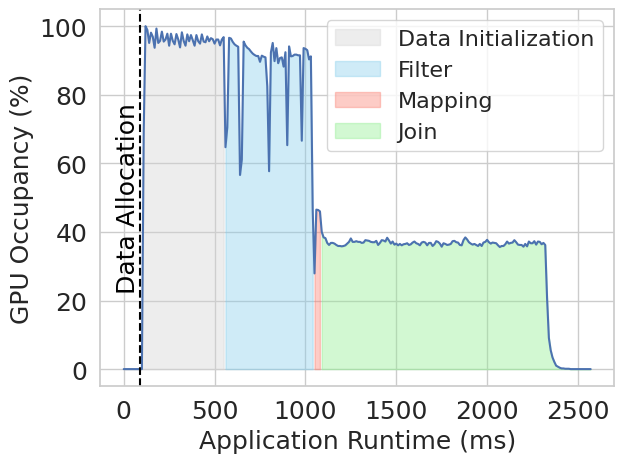

In [205]:
FONTSIZE = 18 

fig, axs = plt.subplots()

operations = [
    {'name': 'Data Initialization', 'start': 0, 'end': p.setup_data_host_time + 30, 'color': 'lightgray'},
    {'name': 'Filter', 'start': p.setup_data_host_time + 30, 'end': (p.setup_data_host_time + p.filter_gpu_time), 'color': 'skyblue'},
    {'name': 'Mapping', 'start': (p.setup_data_host_time + p.filter_gpu_time), 'end': (p.setup_data_host_time + p.filter_gpu_time + p.mapping_host_time), 'color': 'salmon'},
    {'name': 'Join', 'start': (p.setup_data_host_time + p.filter_gpu_time + p.mapping_host_time), 'end': (p.setup_data_host_time + p.filter_host_time + p.mapping_host_time + p.join_host_time), 'color': 'lightgreen'},
    # {'name': 'Other', 'start': (p.setup_data_host_time + p.filter_host_time + p.mapping_host_time + p.join_host_time), 'end': p.total_time, 'color': 'lightgray'}
]

# Plot the GPU utilization as a line
sns.lineplot(data=gpu_df, x='timestamp', y='gpu_util', ax=axs)

# Loop through each operation to fill the corresponding region with its color
for op in operations:
    # Create a mask for timestamps within the operation's interval
    mask = (gpu_df['timestamp'] >= op['start']) & (gpu_df['timestamp'] <= op['end'])
    
    # Fill the area under the curve for this operation
    axs.fill_between(
        gpu_df.loc[mask, 'timestamp'], 
        gpu_df.loc[mask, 'gpu_util'], 
        color=op['color'], 
        alpha=0.4, 
        label=op['name']
    )

# Find the first and last nonzero GPU utilization timestamps
nonzero_mask = gpu_df['gpu_util'] > 0
if nonzero_mask.any():
    first_nonzero_ts = gpu_df.loc[nonzero_mask, 'timestamp'].iloc[0] - 20
    last_nonzero_ts = gpu_df.loc[nonzero_mask, 'timestamp'].iloc[-1]
    
    # Draw vertical dashed lines at the first and last nonzero values
    axs.axvline(first_nonzero_ts, color='black', linestyle='--')
    # axs.axvline(last_nonzero_ts, color='black', linestyle='--')

    # Get overall min and max timestamps from the data
    min_ts = gpu_df['timestamp'].min()
    max_ts = gpu_df['timestamp'].max()
    
    # Highlight regions before the first nonzero and after the last nonzero
    # axs.axvspan(min_ts, first_nonzero_ts, color='gray', alpha=0.2)
    
    # Add vertical text labels on the first and last lines
    # Using the x-axis transform to place text in axis coordinates (0-1 in y)
    axs.text(first_nonzero_ts, .5, 'Data Allocation', transform=axs.get_xaxis_transform(), 
             rotation=90, verticalalignment='center', horizontalalignment='right', color='black', fontsize=FONTSIZE)
    # axs.text(last_nonzero_ts, 0.95, 'Last nonzero', transform=axs.get_xaxis_transform(), 
    #          rotation=90, verticalalignment='top', horizontalalignment='left', color='black')

# Add labels and title
axs.set_xlabel("Application Runtime (ms)", fontsize=14)
axs.set_ylabel("GPU Occupancy (%)", fontsize=FONTSIZE)
axs.grid(True)
axs.legend(fontsize=FONTSIZE-2)
set_font_size(axs, FONTSIZE)

fig.tight_layout()
fig.savefig('./out/plots/gpu_utilization.pdf')
fig.show()

### Performance on Different Hardware Vendors
Instructions to reproduce:
1. Execute SIGMo on each hardware;
2. Collect the output csv in the ./out/SIGMO folder, and name each file according to the manufacturer (e.g. sigmo_nvidia.csv, sigmo_amd.csv, sigmo_intel.csv)
3. Run the following cell;